In [297]:
from sklearn.datasets import fetch_20newsgroups
from matplotlib import pyplot as plt
import numpy as np
from numpy import array

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF

from sklearn import metrics
from sklearn import svm

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import nltk
from nltk import pos_tag

import pandas as pd


# Getting familiar with the dataset

In [298]:
from sklearn.datasets import fetch_20newsgroups
# Refer to the offcial document of scikit-learn for detailed usages:
# http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html
categories = ['comp.graphics', 'comp.sys.mac.hardware']
# The 
twenty_train = fetch_20newsgroups(subset='train', # choose which subset of the dataset to use; can be 'train', 'test', 'all'
#                                   categories=categories, # choose the categories to load; if is `None`, load all categories
                                  shuffle=True,
                                  random_state=42, # set the seed of random number generator when shuffling to make the outcome repeatable across different runs
#                                   remove=['headers'],
                                 )
twenty_test = fetch_20newsgroups(subset='test',
#                                  categories=categories,
                                 shuffle=True,
                                 random_state=42)

In [299]:
# QUESTION 1: To get started, plot a histogram of the number of training documents
# per category to check if they are evenly distributed.


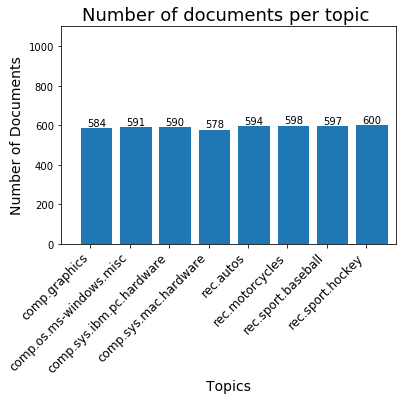

In [300]:
number_of_documents = []

for i in range(len(train_dataset.target_names)):
    number_of_documents.append(len([x for x in train_dataset.target if x == i]))
    
#plot histogram
x_labels = train_dataset.target_names
fig, ax = plt.subplots()
ax.set_xticks([i+0.25 for i in range(1,9)])
ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize = 12)

rects = plt.bar([i for i in range(1,9)], number_of_documents, align='edge')
plt.xlabel('Topics', fontsize = 14)
plt.ylabel('Number of Documents', fontsize = 14)
plt.title('Number of documents per topic ', fontsize = 18)
plt.axis([0.5,9,0,1100])
    
for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1*height, '%d' % int(height), ha='center', va='bottom')
    
plt.show()

# Binary Classification

In [301]:
# 1. Feature Extraction

In [302]:
categories = ['comp.graphics', 'comp.os.ms-windows.misc',
'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
'rec.autos', 'rec.motorcycles',
'rec.sport.baseball', 'rec.sport.hockey']

In [303]:
train_dataset = fetch_20newsgroups(subset='train', categories=categories,
shuffle=True, random_state=42, remove=('headers'))

test_dataset = fetch_20newsgroups(subset='test', categories=categories,
shuffle=True, random_state=42, remove=('headers'))

In [304]:
# QUESTION 2: Use the following specs to extract features from the textual data:
# • Use the default stopwords of the CountVectorizer
# • Exclude terms that are numbers (e.g. “123”, “-45”, “6.7” etc.)
# • Perform lemmatization with nltk.wordnet.WordNetLemmatizer and pos_tag
# • Use min_df=3
# Report the shape of the TF-IDF matrices of the train and test subsets respectively.

In [383]:
# we need to Lemmatize this.
def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 
    
def lemmatize_parse(text):
    wnl = nltk.wordnet.WordNetLemmatizer()
    lemmatize = []
    for word, tag in pos_tag(nltk.word_tokenize(text)):
        if(word.isdigit() or word.isalpha()):
            lemmatize.append(wnl.lemmatize(word.lower(), pos=penn2morphy(tag)))
    return lemmatize

In [394]:
# set lemmatize 
train_data_lemmatized = []
for item in train_dataset.data:
    train_data_lemmatized.append(' '.join(lemmatize_parse(item)))
    
test_dataset_lemmatized = []
for item in test_dataset.data:
    test_dataset_lemmatized.append(' '.join(lemmatize_parse(item)))
    
train_dataset.data = train_data_lemmatized
test_dataset.data = test_dataset_lemmatized

In [396]:
vectorizer = CountVectorizer(min_df=3, stop_words='english')
X_train_counts = vectorizer.fit_transform(train_dataset.data)
X_test_counts = vectorizer.transform(test_dataset.data)

# need to find position of terms where there are alpha_numeric and remove them in term/doc matrix
# alpha_numeric_terms_position = [idx for idx,term in enumerate(vectorizer.get_feature_names()) if term.isdigit()]


In [399]:
# delete term position where it's alpha numeric.
# X_train_counts_clean = np.delete(X_train_counts.toarray(), alpha_num_terms_position, axis=1)
# X_test_counts_clean = np.delete(X_test_counts.toarray(), alpha_num_terms_position, axis=1)

# delete alpha_numeric terms out from original feature_names()
# feature_names = array(vectorizer.get_feature_names())
# feature_names_clean = np.delete(feature_names, alpha_numeric_terms_position, axis=0)


In [ ]:
# generate TFxIDF
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.fit_transform(X_test_counts)


In [400]:
X_train_tfidf.shape

(4732, 16318)

In [401]:
X_test_tfidf.shape

(3150, 16318)

In [402]:
# QUESTION 3: Reduce the dimensionality of the data using the methods above
# • Apply LSI to the TF-IDF matrix corresponding to the 8 categories with k = 50;
# so each document is mapped to a 50-dimensional vector.
# • Also reduce dimensionality through NMF and compare with LSI:
# Which one is larger?

In [411]:
# using LSI
svd = TruncatedSVD(n_components = 50,random_state = 42)
svd_res = svd.fit_transform(X_train_tfidf)
print('LSI method:')
print(svd_res.shape)
print('')

# using NMF
nmf = NMF(n_components=50, init='random', random_state=42)
nmf_res = nmf.fit_transform(X_train_tfidf)
print('NMF method:')
print(nmf_res.shape)
print('')


LSI method:
(4732, 50)

NMF method:
(4732, 50)



In [406]:
# QUESTION 4: Hard margin and soft margin linear SVMs:
# • Train two linear SVMs and compare:
# – Train one SVM with y= 1000 (hard margin), another with y= 0:0001 (soft margin).
# – Plot the ROC curve, report the confusion matrix and calculate the accuracy,
# recall, precision and F-1 score of both SVM classifier. Which
# one performs better?
# – What happens for the soft margin SVM? Why is the case?
# • Use cross-validation to choose y:
# Using a 5-fold cross-validation, find the best value of the parameter 
#  in the range f10kj 􀀀 3  k  3; k 2 Zg. Again, plot the ROC curve and report the
# confusion matrix and calculate

In [408]:
#hard margin
hard_svm = svm.SVC(gamma = 1000)
hard_svm.fit(X_train_tfidf, train_dataset.target)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=1000, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [409]:
predicted = hard_svm.predict(X_test_tfidf.toarray())

In [410]:
pd.crosstab(test_dataset['target'].ravel(), predicted, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,7,All
True,,,
0,4,385,389
1,0,394,394
2,0,392,392
3,0,385,385
4,0,396,396
5,0,398,398
6,0,397,397
7,0,399,399
All,4,3146,3150


In [ ]:
#soft margin

LSI method:
(4732, 50)

NMF method:
(4732, 50)



SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=1000, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

array([7, 7, 7, ..., 7, 7, 7])

Predicted,0,7,All
True,,,
0,4,385,389
1,0,394,394
2,0,392,392
3,0,385,385
4,0,396,396
5,0,398,398
6,0,397,397
7,0,399,399
All,4,3146,3150
